## Library Importation

In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from skimage.feature import graycomatrix, graycoprops
from skimage import color, io
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, DenseNet121,ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten,Dropout
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Functions to extract image features for clustering

In [2]:
def get_plant_color(image, bins=(16,16,16)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 176, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()


In [3]:
def get_plant_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [3], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return [contrast, dissimilarity, homogeneity]

In [4]:
def get_plant_shape(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)
    labeled = label(thresh)
    regions = regionprops(labeled)
    if len(regions) > 0:
        largest_region = max(regions, key=lambda r: r.area)
        area = largest_region.area
        perimeter = largest_region.perimeter
        return [area, perimeter]
    else:
        return [0, 0]

## folders for the images

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
data_store = "Images_1"
group_folder_for_clusters = 'grouped_images(1)'

## get images features to group them

In [7]:
plant_features = []
image_paths = []
if not os.path.exists(group_folder_for_clusters):
    os.makedirs(group_folder_for_clusters)
for plant_image_name in os.listdir(data_store):
    img_path = os.path.join(data_store, plant_image_name)
    if os.path.isfile(img_path):
        image_paths.append(img_path)
        img = cv2.imread(img_path)
        if img is not None:
            plant_color = get_plant_color(img)
            plant_texture = get_plant_texture(img)
            plant_shape = get_plant_shape(img)
            all_features_for_each_plant = np.concatenate([plant_color, plant_texture, plant_shape])
            plant_features.append(all_features_for_each_plant)
        else:
            print(f"issue with image")
    else:
        print(f"Skipped image at: {img_path}")

## Perform K-means clustering

Elbow method to identify clusters

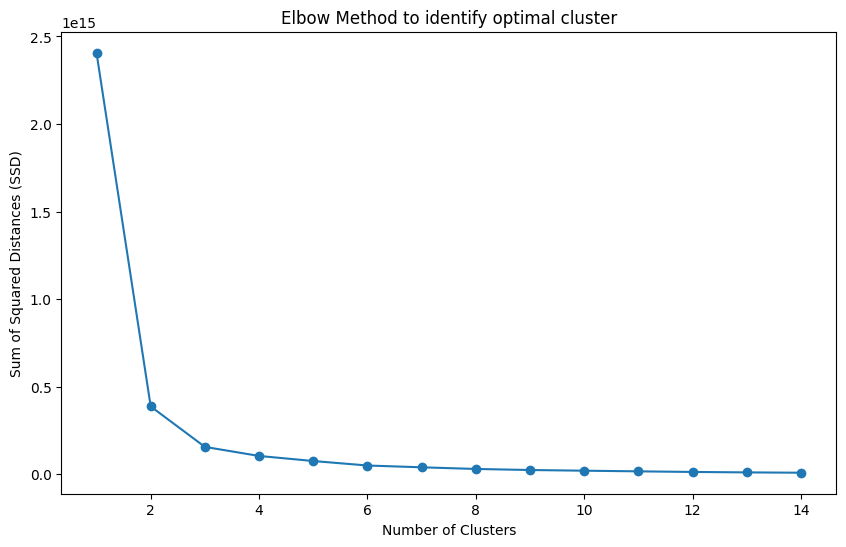

In [8]:
ftr_array = np.array(plant_features)
range_of_clusters = range(1, 15) 
sum_squared_distance = []
for x in range_of_clusters:
    kmeans = KMeans(n_clusters=x, random_state=42)
    kmeans.fit(ftr_array)
    sum_squared_distance.append(kmeans.inertia_) 
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, sum_squared_distance, marker='o')
plt.title('Elbow Method to identify optimal cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.show()


In [9]:
k_mns = KMeans(n_clusters=3, random_state=42)
groups = k_mns.fit_predict(ftr_array)
sl_avg = silhouette_score(ftr_array, groups)
print(f'Silhouette Score from clustering the species:',sl_avg)

Silhouette Score from clustering the species: 0.7737803568393228


# grouping the images into folders

In [10]:
grouped_imgs = {}
for i, group_id in enumerate(groups):
    if group_id not in grouped_imgs:
        grouped_imgs[group_id] = []
    grouped_imgs[group_id].append(image_paths[i])
    group_folder = os.path.join(group_folder_for_clusters, f'Class_{chr(65 + group_id)}')
    if not os.path.exists(group_folder):
        os.makedirs(group_folder)
    shutil.copy(image_paths[i], group_folder)

# sample images in each cluster

Class_B:


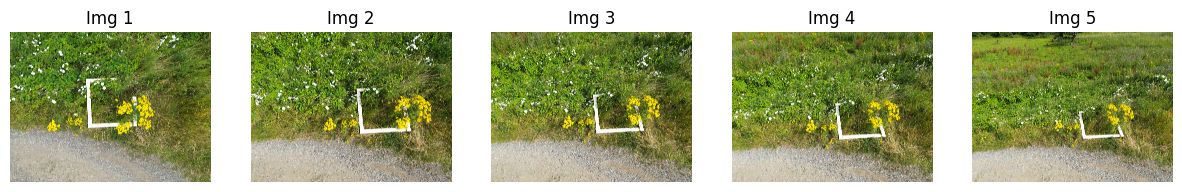

Class_C:


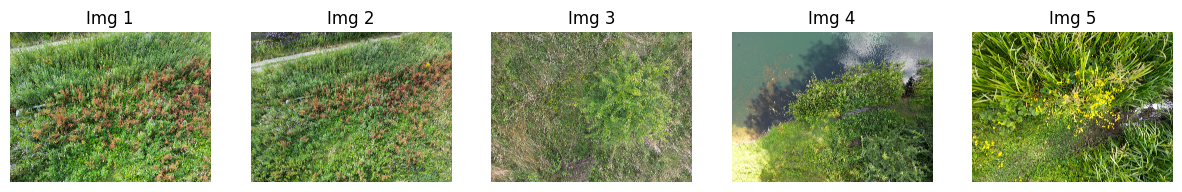

Class_A:


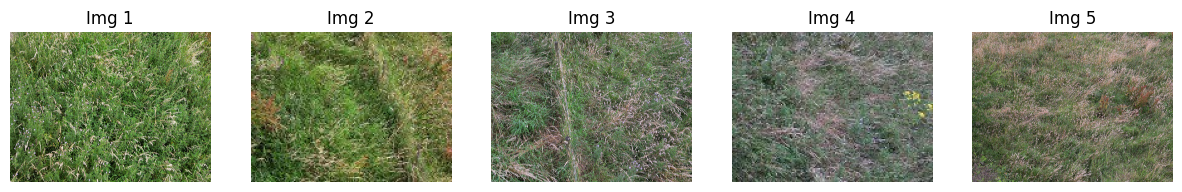

In [11]:
for group_id, img_paths in grouped_imgs.items():
    print(f"Class_{chr(65 + group_id)}:")
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(img_paths[:5]):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Img {i+1}")
        plt.axis('off')
    plt.show()

Getting the grouped data

In [20]:
data_folder = 'grouped_images(1)'
data = image_dataset_from_directory(data_folder,image_size=(224, 224), batch_size=32,label_mode='categorical')
num_classes = len(data.class_names)

Found 63 files belonging to 3 classes.


# Split dataset into training and validation sets

In [21]:
data_size = len(data.file_paths)
train_size=int(len(data)*.9)
val_size=int(len(data)*.1)+1
train_data=data.take(train_size)
val_data=data.skip(train_size).take(val_size)
train_data = train_data.map(lambda x, y: (x / 255.0, y))
val_data = val_data.map(lambda x, y: (x / 255.0, y))

In [22]:
def augment(img, label):
    image = tf.image.random_flip_left_right(img)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) 
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label
train_data = train_data.map(lambda x, y: augment(x, y))
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


## =BUILDING CLASSIFICATION MODELS=

# VGG16 Model

In [23]:
vgg_model_b = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
x_vgg = vgg_model_b.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
x_vgg = Dense(128, activation='relu')(x_vgg)
predictions_vgg = Dense(num_classes, activation='softmax')(x_vgg)
vgg_ml = Model(inputs=vgg_model_b.input, outputs=predictions_vgg)
for layer in vgg_model_b.layers:
    layer.trainable = False
x = vgg_ml.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax')(x) 
vgg_ml = Model(inputs=vgg_ml.input, outputs=x)
vgg_ml.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
vgg_history = vgg_ml.fit(train_data,validation_data=val_data,epochs=50)

Epoch 1/50
1/1 [==============================] - 79s 79s/step - loss: 1.0891 - accuracy: 0.3750 - val_loss: 1.0729 - val_accuracy: 0.5161
Epoch 2/50
1/1 [==============================] - 58s 58s/step - loss: 1.0640 - accuracy: 0.5625 - val_loss: 1.0915 - val_accuracy: 0.3871
Epoch 3/50
1/1 [==============================] - 59s 59s/step - loss: 1.1052 - accuracy: 0.3125 - val_loss: 1.0564 - val_accuracy: 0.5484
Epoch 4/50
1/1 [==============================] - 61s 61s/step - loss: 1.0863 - accuracy: 0.4375 - val_loss: 1.0551 - val_accuracy: 0.5484
Epoch 5/50
1/1 [==============================] - 52s 52s/step - loss: 1.0542 - accuracy: 0.5312 - val_loss: 1.0677 - val_accuracy: 0.4839
Epoch 6/50
1/1 [==============================] - 50s 50s/step - loss: 1.0860 - accuracy: 0.5000 - val_loss: 1.0551 - val_accuracy: 0.5161
Epoch 7/50
1/1 [==============================] - 57s 57s/step - loss: 1.0869 - accuracy: 0.5000 - val_loss: 1.0544 - val_accuracy: 0.5161
Epoch 8/50
1/1 [===========

In [24]:
loss, accuracy = vgg_ml.evaluate(val_data, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 22s 22s/step - loss: 1.0570 - accuracy: 0.3871
Test Loss: 1.056993007659912
Test Accuracy: 0.3870967626571655


Loss values for VGG Model

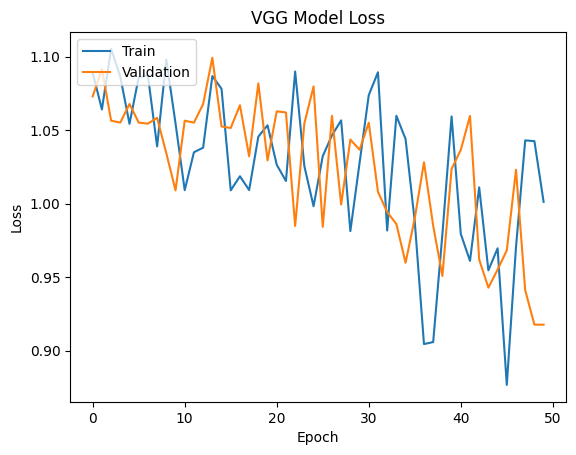

In [25]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Accuracy scores for VGG Model

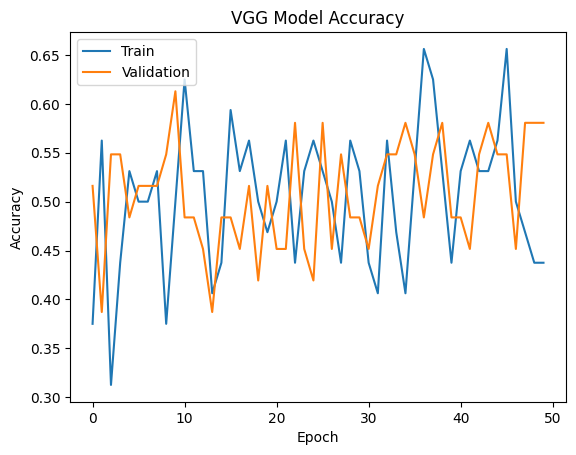

In [26]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# DenseNet121 Model

In [27]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_densenet = base_model_densenet.output
x_densenet = GlobalAveragePooling2D()(x_densenet)
x_densenet = Dense(128, activation='relu')(x_densenet)
predictions_densenet = Dense(num_classes, activation='softmax')(x_densenet)
densenet_model = Model(inputs=base_model_densenet.input, outputs=predictions_densenet)
for layer in base_model_densenet.layers:
    layer.trainable = False
x = densenet_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax')(x) 
densenet_model = Model(inputs=densenet_model.input, outputs=x)
densenet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
densenet_history = densenet_model.fit(train_data,validation_data=val_data,epochs=50)


Epoch 1/50
1/1 [==============================] - 74s 74s/step - loss: 1.0816 - accuracy: 0.3750 - val_loss: 1.0306 - val_accuracy: 0.5806
Epoch 2/50
1/1 [==============================] - 41s 41s/step - loss: 1.0771 - accuracy: 0.3438 - val_loss: 1.0350 - val_accuracy: 0.5806
Epoch 3/50
1/1 [==============================] - 42s 42s/step - loss: 1.0045 - accuracy: 0.7188 - val_loss: 0.9738 - val_accuracy: 0.6452
Epoch 4/50
1/1 [==============================] - 42s 42s/step - loss: 1.0370 - accuracy: 0.5000 - val_loss: 0.9962 - val_accuracy: 0.6129
Epoch 5/50
1/1 [==============================] - 42s 42s/step - loss: 1.0213 - accuracy: 0.6250 - val_loss: 0.9981 - val_accuracy: 0.4839
Epoch 6/50
1/1 [==============================] - 42s 42s/step - loss: 1.0300 - accuracy: 0.4688 - val_loss: 0.9827 - val_accuracy: 0.6452
Epoch 7/50
1/1 [==============================] - 40s 40s/step - loss: 0.9772 - accuracy: 0.6875 - val_loss: 0.9930 - val_accuracy: 0.6129
Epoch 8/50
1/1 [===========

In [28]:
loss, accuracy = densenet_model.evaluate(val_data, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 14s 14s/step - loss: 0.6327 - accuracy: 0.7742
Test Loss: 0.632668137550354
Test Accuracy: 0.774193525314331


Loss values for DenseNet

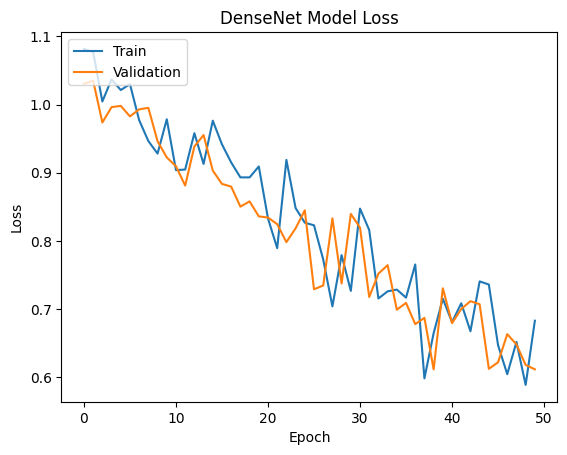

In [29]:
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('DenseNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Accuracy Scores for DenseNet

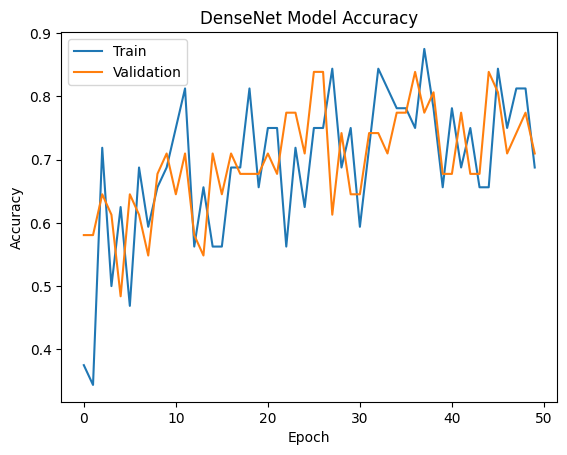

In [30]:
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('DenseNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Restnet Model

In [31]:
rest_net = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_restnet = rest_net.output
x_restnet = GlobalAveragePooling2D()(x_restnet)
x_restnet = Dense(128, activation='relu')(x_restnet)
predictions_restnet = Dense(num_classes, activation='softmax')(x_restnet)
restnet_model = Model(inputs=rest_net.input, outputs=predictions_restnet)
for layer in rest_net.layers:
    layer.trainable = False
x = restnet_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax')(x) 
restnet_model = Model(inputs=restnet_model.input, outputs=x)
restnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
restnet_history = restnet_model.fit(train_data,validation_data=val_data,epochs=50)

Epoch 1/50
1/1 [==============================] - 47s 47s/step - loss: 1.0754 - accuracy: 0.4375 - val_loss: 1.0579 - val_accuracy: 0.5161
Epoch 2/50
1/1 [==============================] - 30s 30s/step - loss: 1.0642 - accuracy: 0.5000 - val_loss: 1.0517 - val_accuracy: 0.5484
Epoch 3/50
1/1 [==============================] - 33s 33s/step - loss: 1.0784 - accuracy: 0.5000 - val_loss: 1.0350 - val_accuracy: 0.6129
Epoch 4/50
1/1 [==============================] - 37s 37s/step - loss: 1.0644 - accuracy: 0.5938 - val_loss: 1.0574 - val_accuracy: 0.5161
Epoch 5/50
1/1 [==============================] - 36s 36s/step - loss: 1.0465 - accuracy: 0.5938 - val_loss: 1.0749 - val_accuracy: 0.4516
Epoch 6/50
1/1 [==============================] - 40s 40s/step - loss: 1.0636 - accuracy: 0.5000 - val_loss: 1.0395 - val_accuracy: 0.5484
Epoch 7/50
1/1 [==============================] - 39s 39s/step - loss: 1.0560 - accuracy: 0.5000 - val_loss: 1.0348 - val_accuracy: 0.5484
Epoch 8/50
1/1 [===========

In [32]:
loss, accuracy = restnet_model.evaluate(val_data, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 [==============================] - 8s 8s/step - loss: 0.9815 - accuracy: 0.5806
Test Loss: 0.9815472960472107
Test Accuracy: 0.5806451439857483


Loss values for Restnet

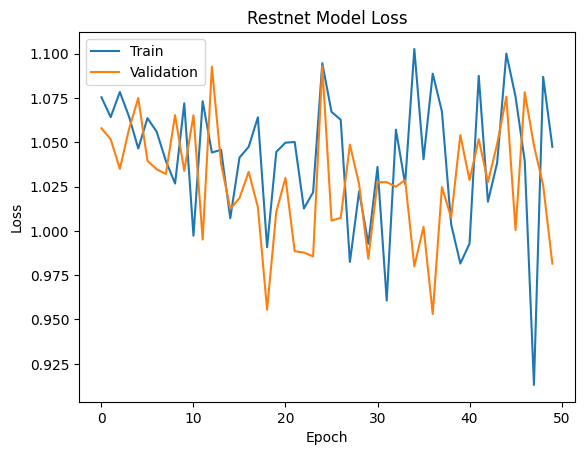

In [33]:
plt.plot(restnet_history.history['loss'])
plt.plot(restnet_history.history['val_loss'])
plt.title('Restnet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Accuracy scores for Restnet

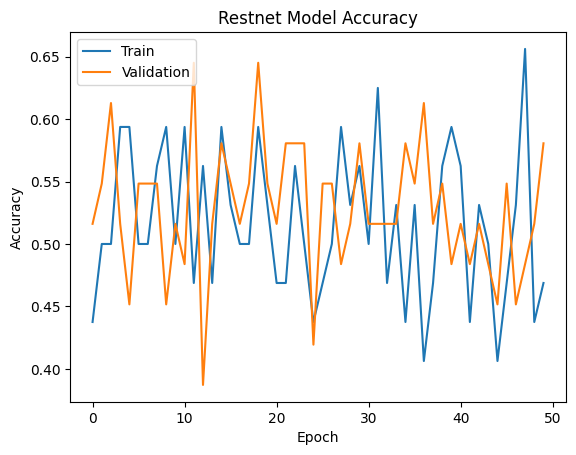

In [34]:
plt.plot(restnet_history.history['accuracy'])
plt.plot(restnet_history.history['val_accuracy'])
plt.title('Restnet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing algorithm on an Image

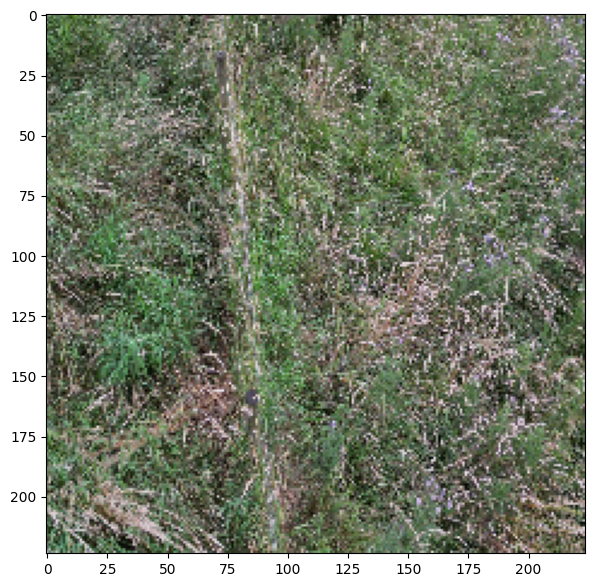

1/1 [==============================] - 0s 130ms/step
CLASS A


In [38]:
test_img=plt.imread(r'grouped_images(1)\Class A\DJI_0731.JPG')
resize=tf.image.resize(test_img,(224,224))
plt.figure(figsize=(15,7))
plt.imshow(resize.numpy().astype(int))
plt.show()
y_pred=densenet_model.predict(np.expand_dims(resize/255,0))
y_pred =np.argmax(y_pred, axis=1)[0]
if y_pred==0:
    print('CLASS A')
elif y_pred==1:
    print('CLASS B')
else:
    print('CLASS C')

In [36]:
densenet_model.save('densenet_model.h5')

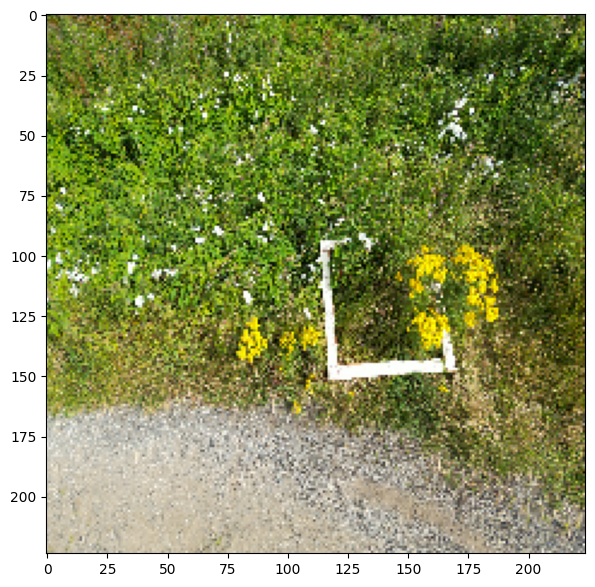

1/1 [==============================] - 0s 125ms/step
CLASS B


In [37]:
test_img=plt.imread(r'grouped_images(1)\Class B\DJI_0674.JPG')
resize=tf.image.resize(test_img,(224,224))
plt.figure(figsize=(15,7))
plt.imshow(resize.numpy().astype(int))
plt.show()
y_pred=densenet_model.predict(np.expand_dims(resize/255,0))
y_pred =np.argmax(y_pred, axis=1)[0]
if y_pred==0:
    print('CLASS A')
elif y_pred==1:
    print('CLASS B')
else:
    print('CLASS C')

<Figure size 2000x700 with 0 Axes>

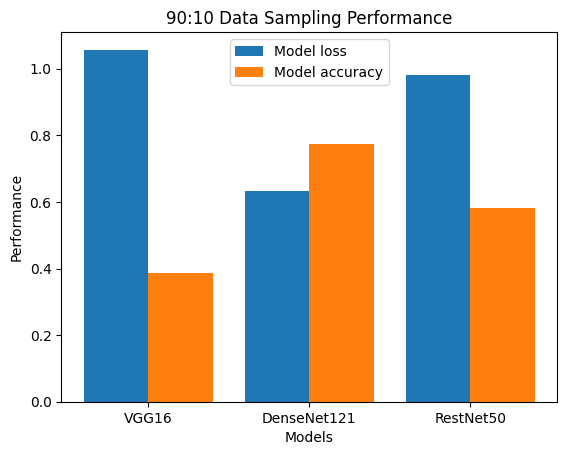

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20,7))
models =['VGG16', 'DenseNet121','RestNet50']
loss= [1.0569, 0.6326, 0.9815]
accuracy=[0.3870, 0.7741, 0.5806]
ds = np.arange(len(models))
wd = 0.4
fig, ax = plt.subplots()
bar1 = ax.bar(ds - wd/2, loss, wd, label='Model loss')
bar2 = ax.bar(ds + wd/2, accuracy, wd, label='Model accuracy')
ax.set_xlabel('Models')
ax.set_ylabel('Performance')
ax.set_title('90:10 Data Sampling Performance')
ax.set_xticks(ds)
ax.set_xticklabels(models)
ax.legend()
plt.show()